# CMP7005 – Programming for Data Analysis
## PRAC1 – Air Quality Application (Jupyter Notebook)

## Task 1: Data Handling

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Step 1: Define data directory (update the path below to your dataset folder)
data_dir = 'PRSA_Data_20130301-20170228'  # Change this!

# Step 2: Select four files (Urban, Suburban, Rural, Industrial)
files = {
    'Aotizhongxin (Urban)': 'PRSA_Data_Aotizhongxin_20130301-20170228.csv',
    'Changping (Suburban)': 'PRSA_Data_Changping_20130301-20170228.csv',
    'Huairou (Rural)': 'PRSA_Data_Huairou_20130301-20170228.csv',
    'Nongzhanguan (Industrial)': 'PRSA_Data_Nongzhanguan_20130301-20170228.csv'
}

dfs = []

# Step 3: Load and label each dataset
for site_name, filename in files.items():
    path = os.path.join(data_dir, filename)
    df = pd.read_csv(path)
    df['site'] = site_name
    dfs.append(df)

# Step 4: Merge datasets
combined_df = pd.concat(dfs, ignore_index=True)
print("Data merged successfully. Shape:", combined_df.shape)

# Step 5: Drop duplicates
combined_df.drop_duplicates(inplace=True)

# Step 6: Create datetime column
combined_df['datetime'] = pd.to_datetime(combined_df[['year', 'month', 'day', 'hour']])
combined_df.set_index('datetime', inplace=True)

# Step 7: Drop rows with critical pollutant nulls
critical_cols = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']
combined_df.dropna(subset=critical_cols, inplace=True)

# Step 8: Fill remaining missing values (linear interpolation)
combined_df.interpolate(method='linear', inplace=True)

# Step 9: Feature Engineering
combined_df['season'] = combined_df['month'] % 12 // 3 + 1  # 1=Winter, 2=Spring, etc.

# Step 10: Save cleaned dataset
output_path = 'cleaned_air_quality.csv'
combined_df.to_csv(output_path)
print(f"Cleaned dataset saved as: {output_path}")

Data merged successfully. Shape: (140256, 19)


/tmp/ipykernel_74655/1791472837.py:42: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  combined_df.interpolate(method='linear', inplace=True)


Cleaned dataset saved as: cleaned_air_quality.csv


## Task 2: Exploratory Data Analysis (EDA)

hape of the dataset: (129930, 20)

 Data Types:
No           int64
year         int64
month        int64
day          int64
hour         int64
PM2.5      float64
PM10       float64
SO2        float64
NO2        float64
CO         float64
O3         float64
TEMP       float64
PRES       float64
DEWP       float64
RAIN       float64
wd          object
WSPM       float64
station     object
site        object
season       int64
dtype: object

 Missing Values:
No           0
year         0
month        0
day          0
hour         0
PM2.5        0
PM10         0
SO2          0
NO2          0
CO           0
O3           0
TEMP         0
PRES         0
DEWP         0
RAIN         0
wd         581
WSPM         0
station      0
site         0
season       0
dtype: int64

 Summary Statistics:
                   No          year          month            day  \
count   129930.000000  129930.00000  129930.000000  129930.000000   
unique            NaN           NaN            NaN            NaN  

/tmp/ipykernel_74655/3013404972.py:25: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  combined_df.interpolate(method='linear', inplace=True)


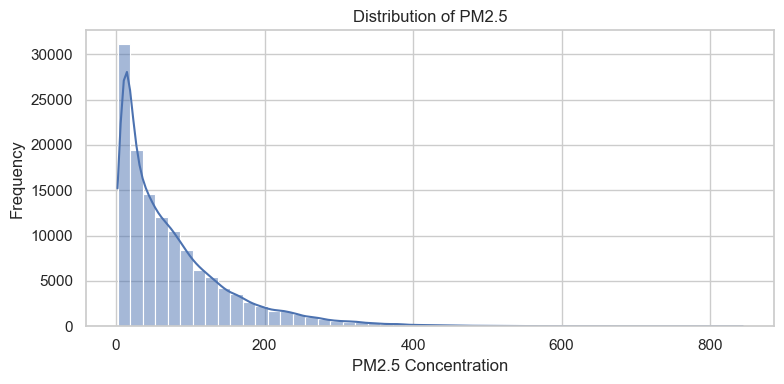

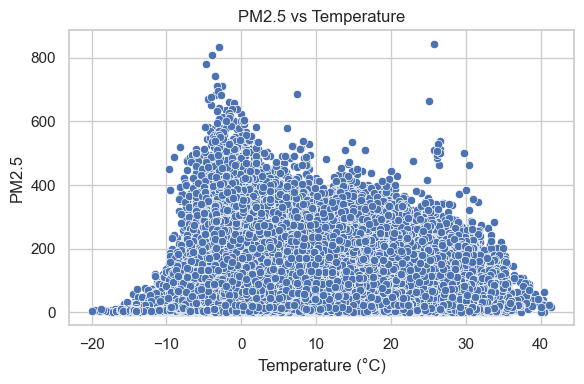

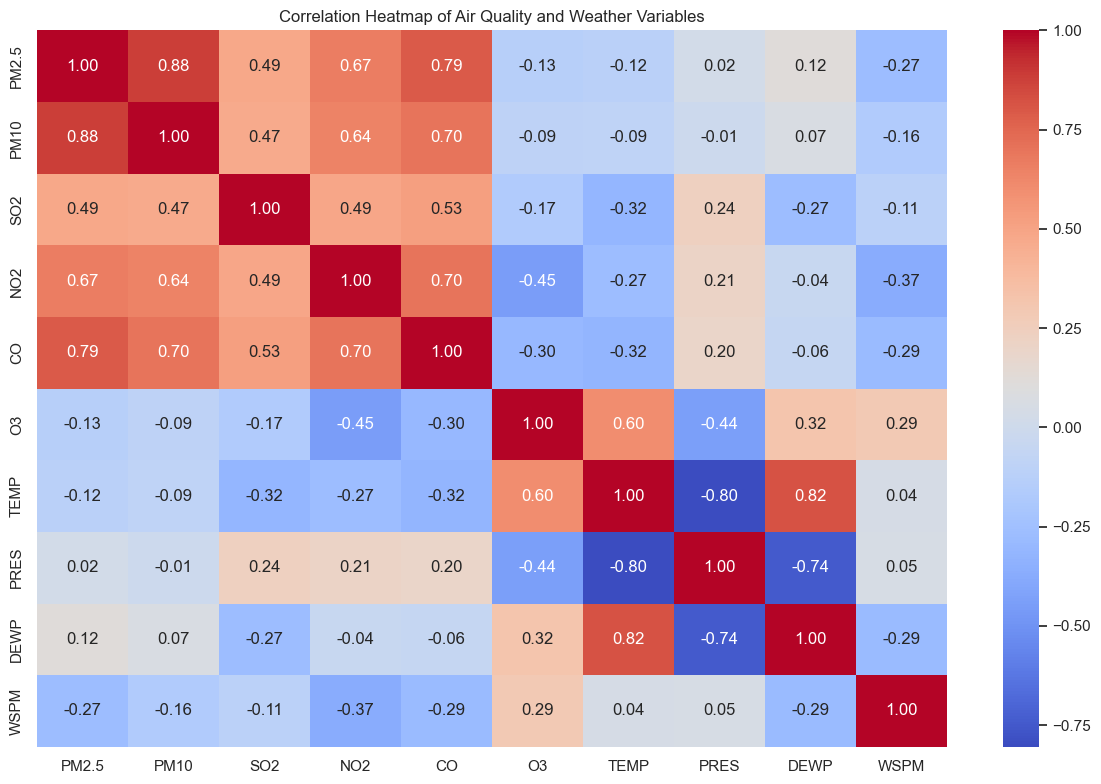

In [2]:
# --- Step 2a: Fundamental Data Understanding ---
print("hape of the dataset:", combined_df.shape)

print("\n Data Types:")
print(combined_df.dtypes)

print("\n Missing Values:")
print(combined_df.isnull().sum())

print("\n Summary Statistics:")
print(combined_df.describe(include='all'))

# --- Step 2b: Data Preprocessing ---
print("\n Dropping duplicates...")
combined_df.drop_duplicates(inplace=True)

print(" Creating 'datetime' column...")
combined_df['datetime'] = pd.to_datetime(combined_df[['year', 'month', 'day', 'hour']])
combined_df.set_index('datetime', inplace=True)

print(" Dropping rows with missing critical pollutant values...")
combined_df.dropna(subset=['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3'], inplace=True)

print(" Interpolating remaining missing values...")
combined_df.interpolate(method='linear', inplace=True)

print(" Adding 'season' as a feature...")
combined_df['month'] = combined_df['month'].astype(int)
combined_df['season'] = combined_df['month'] % 12 // 3 + 1  # Winter=1, Spring=2, etc.

# --- Step 2c: Statistics & Visualizations ---

# Set up visual style
sns.set(style="whitegrid")

# Histogram: PM2.5
plt.figure(figsize=(8, 4))
sns.histplot(combined_df['PM2.5'].dropna(), bins=50, kde=True)
plt.title('Distribution of PM2.5')
plt.xlabel('PM2.5 Concentration')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Scatter Plot: PM2.5 vs Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='TEMP', y='PM2.5', data=combined_df)
plt.title('PM2.5 vs Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('PM2.5')
plt.tight_layout()
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 8))
cols = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'WSPM']
corr = combined_df[cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Air Quality and Weather Variables')
plt.tight_layout()
plt.show()


## Task 3: Model Building

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Select features and target
features = ['PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'WSPM']
target = 'PM2.5'

# Drop any remaining rows with nulls in selected columns
ml_df = combined_df[features + [target]].dropna()

# Split data
X = ml_df[features]
y = ml_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Linear Regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predict
y_pred = model.predict(X_test_scaled)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Output results
print("\n Model Evaluation:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")





 Model Evaluation:
Mean Absolute Error (MAE): 19.37
Root Mean Squared Error (RMSE): 29.64
R-squared (R²): 0.85
